
# Задание:
----

<br>

Вам предоставлен анонимизированные результаты **реального A/B тестирования**, проходившего когда-то в нашем отделе (`ab_test_ensembles.csv`). В тесте было два варианта работы сервиса - `standard` и `svm_ensemble_v_1_22`, где работали несколько моделей классификации для целей сервиса.

<br>


------
Вам, как специалистам по машинному обучению предстоит ответить на **2 главных вопроса:**

1. Стоит ли нам оставить старый вариант работы сервиса или заменить его на вариант работы с моделями классификации (используем всю выборку 200к+ пользователей).
2. Кроме того, посчитайте вывод для типа пользователей (`user_type`). Стоит ли для новых (старых) пользователей оставить старый (новый) вариант работы сервиса.


<br>

Для того, чтобы освежить в памяти процесс тестирования статистических гипотез, непомню, что тестирование состоит из следующих частей:
1. Дизайн эксперимента.
2. Подготовка и запуск эксперимента.
3. Сбор данных и аналитика полученных данных.
4. Визуализация результатов тестирования.
5. Тестирование гипотез.
6. Вывод и интерпритация результатов.

-----

#### Критерии оценки задания:

1. **Первое, что будет проверяться - вывод полученных результатов**, в случае если выводы сделаны не правильно, задание считается проваленным и на этом этап проверки заканчивается (пропускаются этапы код-ревью, оформления и визуализации, качество кода).
2. В случае если результаты и интерпритация результатов оказались верны, проводится код-ревью и проверка этапа визуализаций, поиск проблемных точек, точек роста.
3. **Максимальный балл** который можно получить, выполнив текущее задание: **2 балла за 1 вопрос, 2 балла за 2 вопрос и 1 балл за эффективный и аккуратный код.


Удачи, примените все свои навыки, которые вам доступны на данный момент и покажите на что вы способны!

#### Import required modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn


In [2]:
df = pd.read_csv('ab_test_ensembles.csv')
df.columns

Index(['user_id', 'timestamp', 'group', 'variants', 'converted', 'location',
       'age_group', 'user_type'],
      dtype='object')

Look at info and check for null values

In [3]:
print(df.info())
df['variants'].value_counts()
df.isnull().value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB
None


user_id  timestamp  group  variants  converted  location  age_group  user_type
False    False      False  False     False      False     False      False        294478
Name: count, dtype: int64

In [4]:
df.head(5)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user


As i can see we have clear, balanced dataset. 
The ony thing i want to do is to delete users which has contradictions
between 'group' and 'variants' columns because this data could be wrong.
And 'converted' could be transformed to "bool" datatype

In [5]:
df['converted'] = df['converted'].astype(bool)
sub_df = df[(df['variants'] == 'svm_ensemble_v_1_22') & 
        (df['group'] == 'treatment') |
        (df['variants'] == 'standard') &
        (df['group'] == 'control')
        ]
df.head(5)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,False,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,False,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,False,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,False,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,True,United Kingdom,42-49,registered_user


Now dataset is ready to be dealt with.
Let's look at converted values for each group

In [6]:
df = sub_df
df.reset_index(inplace=True, drop=True)
df.head(2)
pd.crosstab(df["group"], df["converted"])

converted,False,True
group,,
control,127785,17489
treatment,128047,17264


In [7]:
from scipy.stats import chi2_contingency

def chi2_con_test(data):
    chi2, p, dof, ex = chi2_contingency(data)
    alpha = 0.05

    print('p=%.4f , alpha=%.2f '%(p,alpha))
    if p > alpha:
        print('Two verisions have no significant difference')
    else:
        print('Two verisions have a significant difference')

In [8]:
cross_table = pd.crosstab(df["group"], df["converted"])
cross_table

converted,False,True
group,,
control,127785,17489
treatment,128047,17264


In [9]:
chi2_con_test(cross_table)

p=0.1916 , alpha=0.05 
Two verisions have no significant difference


In global populatuion svm_ensemble_v_1_22 has no statisticaly meanful influence on conversion

### User type split

split data set into two for each user type

In [10]:
df_old = df[df['user_type'] == 'registered_user']
df_new = df[df['user_type'] == 'new_user']

Make a cross table for each subdataset

In [16]:
cross_table_old = pd.crosstab(df_old["group"], df_old["converted"])
cross_table_new = pd.crosstab(df_new["group"], df_new["converted"])
cross_table_new


converted,False,True
group,,
control,63991,8800
treatment,63978,8504


Make chi squared test for each group

In [12]:
print('results of chi^2 test for old users:\n')
chi2_con_test(cross_table_old)
print('*'*50)
print('results of chi^2 test for new users:\n')
chi2_con_test(cross_table_new)

results of chi^2 test for old users:

p=0.8184 , alpha=0.05 
Two verisions have no significant difference
**************************************************
results of chi^2 test for new users:

p=0.0365 , alpha=0.05 
Two verisions have a significant difference


Seems like svm_ensemble_v_1_22 has signifiant influence on new users
Lets look at this influence

In [13]:
df_new.groupby('group').agg(converted =('converted', 'mean'))

,converted
group,
control,0.120894
treatment,0.117326


Well, influence on new players conversion is negative, which means that we better not to launch
svm_ensemble_v_1_22 in production at this moment

<BarContainer object of 2 artists>

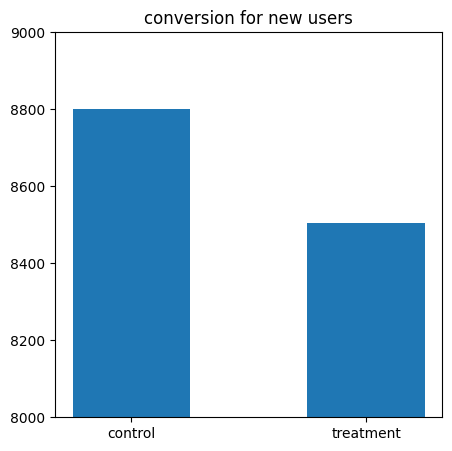

In [91]:
cross_table_new.loc['control']
fig = plt.figure(figsize=(5, 5,))
plt.ylim(8000, 9000)
plt.title('conversion for new users')
plt.bar(cross_table_new.index,cross_table_new[True],width=0.5)